# CLASSIFICATION WEEK 6

### **Objective**

In this notebook we will solve the same problem of recognizing Handwritten digits using Logistic regression model.

### **Imports**


In [1]:
# Common imports 
import numpy as np
from pprint import pprint  

# to make this notebook's output stable across runs
np.random.seed(42) 

# sklearn specific imports 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import make_pipeline 
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model  import SGDClassifier, RidgeClassifier, LogisticRegression 
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict 

# log loss is also known as cross entropy loss
from sklearn.metrics import log_loss 
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import precision_score, recall_score, classification_report 
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_curve, roc_auc_score 

#scipy 
from scipy.stats import loguniform 

# To plot pretty figures 
%matplotlib inline 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns;sns.set()

# global settings 
mpl.rc('axes',labelsize=14) 
mpl.rc('xtick',labelsize=12) 
mpl.rc('ytick',labelsize=12) 
mpl.rc('figure',figsize=(8,6))


In [2]:
# Ignore all warnings (convergence..) by sklearn
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

## **Handwritten Digit Classification** 

* We are going to use **LogisticRegression** (despite it's name) to classify a given digit image. Again, we first apply the model for binary classification and then extend it to multiclass classification.

* Suppose we want to recognize whether the given image is of digit zero or not (digits other than zero). Then the problem could be case as binary classification problem.

* The first step is to create a dataset that contains collection of digit images (also called examples, samples) written by humans. Then each image should be labelled properly.

* Fortunately, we have a standard benchmark dataset called **MNIST**.

In [ ]:
from sklearn.datasets import fetch_openml

# it returns the data and labels as a panda dataframe.
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

The data matrix $X$ and the respective label vector $y$ need to be converted to numpy array by calling a `to_numpy` method.

In [ ]:
X = np.array(X)

In [ ]:
y = np.array(y)

#### **Preprocessing** 

* Unlike perceptron, where scaling the range is optional(but recommended), sigmoid requires range between 0 to 1.

* Contemplate the consequence if we don't apply the scaling operation on the input datapoints.

* **NOTE** : **Do not** apply mean centering as it removes zeros from the data, however zeros should be zeros in the dataset.

* Since we are using only one preprocessing step, using `pipeline` may not be required.

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
print('Mean of the features : ', np.mean(X))
print('Standard Deviation : ', np.std(X))
print('Minimum value : ', np.min(X))
print('Maximum value : ', np.max(X))

Let's get some information about the dataset. 


In [31]:
print('Number of targets : {0} ,type : {1}'.format(X.shape[0] ,X.dtype))
print('Number of features : {0}'.format(X.shape[1]))
print()
print('Number of classes : {0} ,type : {1}'.format(len(np.unique(y)) ,y.dtype))
print('Labels : {0}'.format(np.unique(y)))

Number of targets : 70000 ,type : float64
Number of features : 784

Number of classes : 10 ,type : object
Labels : ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']



Note that the labels are of string data type.

#### **Data visualization**

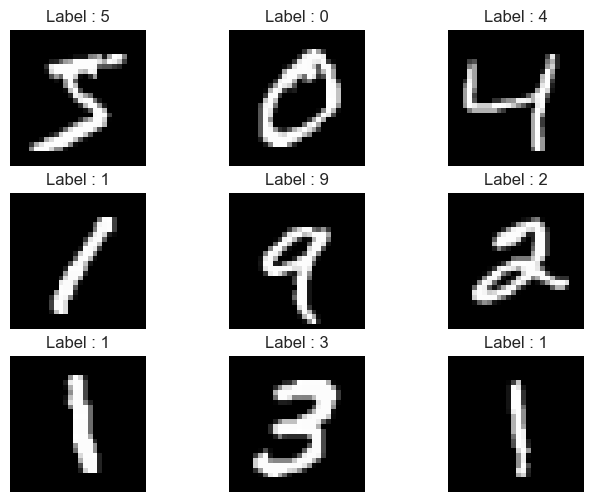

In [32]:
num_images = 9 
factor = int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 

for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Label : {0}'.format(str(y[index+j])))
        ax[i,j].set_axis_off()

#### **Data splitting**

In [33]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before proceeding further, we need to check whether the datasset is balanced or imbalanced. 

We can do it by plotting the distribution of samples in each classes. 

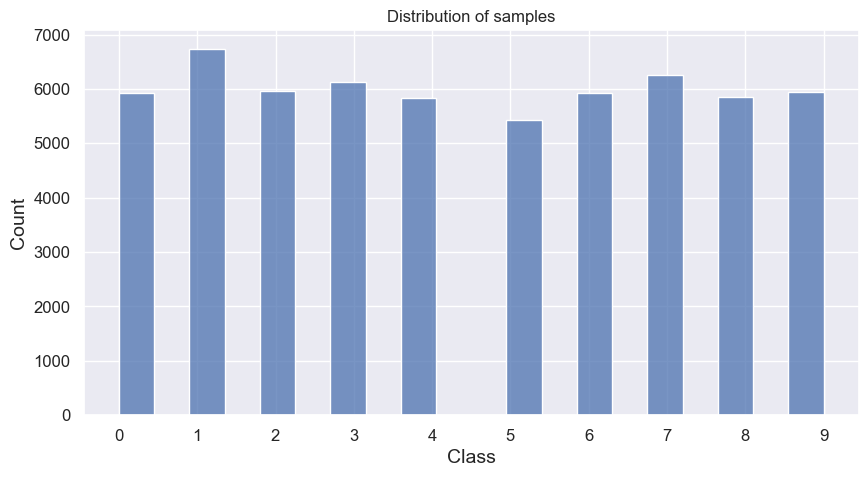

In [34]:
plt.figure(figsize=(10,5))
sns.histplot(data=np.int8(y_train) ,binwidth=0.45 ,bins=11)

plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9] ,label=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## **Binary Classification : 0 - Detector** 

* Let us start with a simple classification problem, that is, binary classification.

* Since the original label vector contains 10 classes, we need to modify the number of classes to 2. Therefore, the label '0' will be changed to '1' and all other labels(1-9) will be changed to '0' 

* **NOTE: For perceptron we set the negative labels to -1**

In [35]:
# initialize new variables names with all 0.
y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

# find indices of digit 0 image
# remember original labels are of type str not int
indx_0 = np.where(y_train=='0') 

# use those indices to modify y_train_0 & y_test_0 
y_train_0[indx_0] = 1 
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

#### **Visualization of new variables**

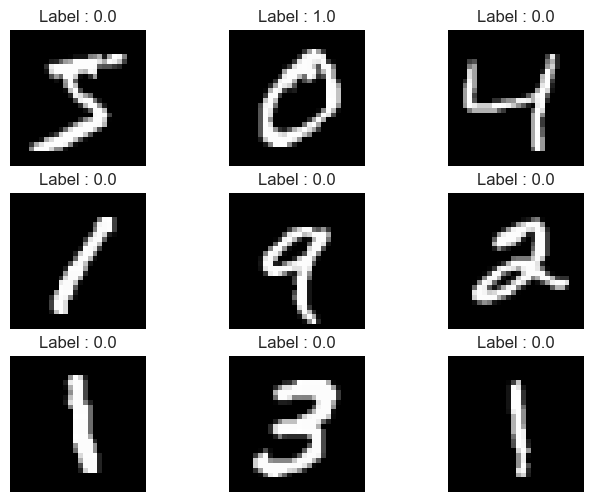

In [36]:
num_images = 9  
factor = np.int(np.sqrt(num_images))

fig, ax = plt.subplots(nrows=factor, ncols=factor,figsize=(8,6))
idx_offset = 0 

for i in range(factor):
    index = idx_offset+ i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title('Label : {0}'.format(str(y_train_0[index+j])))
        ax[i,j].set_axis_off()

## **Model**

### **Baseline Models**

Let us quickly construct a baseline model with the following rule :

1. Count number of samples per class.

2. The model **always output** the class which has highest number of samples.

3. Then calculate the accuracy of the baseline model.

In [37]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == 0)[0])

print(num_pos)
print(num_neg)


5923
54077


In [38]:
base_clf = DummyClassifier(strategy='most_frequent') 
base_clf.fit(X_train,y_train_0)

print(base_clf.score(X_train,y_train_0))

0.9012833333333333


Now the reason is obvious. The model would have predicted 54077 samples correctly just by outputing 0 for all the input samples. 

Therefore the accuracy will be $\frac{54077}{60000} = 90.12 \%$

### **Logistic Regression model** 

Quick recap of various components in the general settings:


1. **Training data** : 

    * consists of features & labels or $(\mathbf X,y)$ 

    * Here, $y$ is a **discrete** number from a finite set.

    * **Features** in this case are **pixel** values of an image.
2. **Model** : 
$$ z = w_0x_0 + w_1x_1+ \ldots + w_mx_m$$

$$ = \mathbf w^{T} \mathbf x$$ 

and passing it through the sigmoid non-linear function (or Logistic function)

$$ \sigma(z)=\frac{1}{1+e^{-z}}$$

3. **Loss function**: 

\begin{equation} 
J(\mathbf w) = -\frac{1}{n} \mathbf \sum [y^{(i)} \log(h_w(\mathbf x^{(i)}))+(1-y^{(i)})(1-\log(h_w(\mathbf x^{(i)})))] 
\end{equation}

4. **Optimization**: 


Let's quickly take a look into the important parameters of the SGDClassifier() estimator:

**class sklearn.linear_model.SGDClassifier** **`(loss='hinge', * ,penalty='l2', alpha=0.0001, l1_ratio = 0.15, fit_intercept =True, max_iter =1000, tol=0.001, shuffle=True, verbose =0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate = 'optimal', eta0=0.0, power_t = 0.5, early_stopping = False, validation_fraction =0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)`**.


* **IMPORTANT** : 
**Setting the loss parameter to `loss=log` makes it a logistic regression classifier**. We may refer to documentation for more details on the `SGDClassifier` class.

* Create an instant of binary classifier (**bin_sgd_clf**) and call the `fit` method to train the model.

* Let's use fit method of `SGDClassifier()` to plot the iteration vs loss curve. (also we could use `partial_fit()` method ) 

* Therefore, to capture the loss for each iterations during training we set the parameters `warm_start =True` and `max_iter=1`


#### **Training without regularization**

Set `eta0 = 0.01,learning_rate = 'constant' ` and `alpha = 0`.

In [39]:
bin_sgd_clf = SGDClassifier(loss='log',
                            penalty='l2',
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729)

loss = []
iter = 100

for i in range(iter):
    bin_sgd_clf.fit(X_train, y_train_0)
    y_pred = bin_sgd_clf.predict_proba(X_train)
    loss.append(log_loss(y_train_0, y_pred))

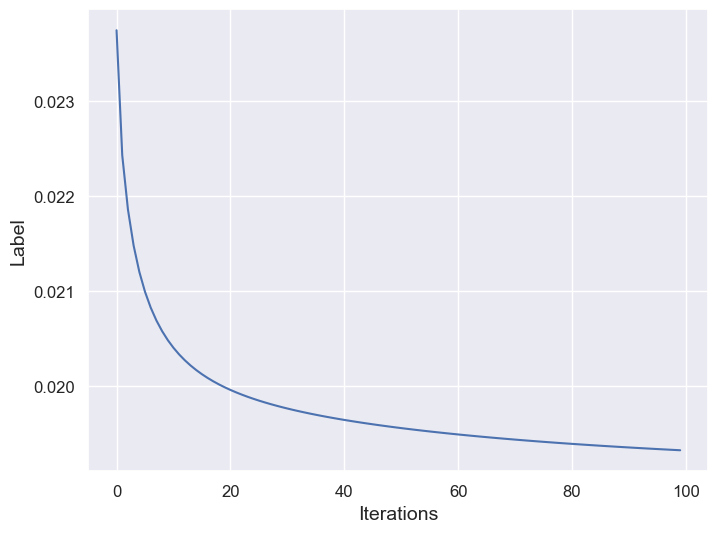

In [40]:
plt.figure()
plt.plot(np.arange(iter), loss)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Label')
plt.show()

Let us calculate the training and testing accuracy of the model.

In [41]:
print('Training accuracy : {0:.4f}'.format(bin_sgd_clf.score(X_train,y_train_0)))
print('Testing accuracy : {0:.4f}'.format(bin_sgd_clf.score(X_test,y_test_0)))

Training accuracy : 0.9943
Testing accuracy : 0.9917


We know that accuracy alone is not a good metric for binary classification.

So let's compute Precision, recall and f1-score for the model.

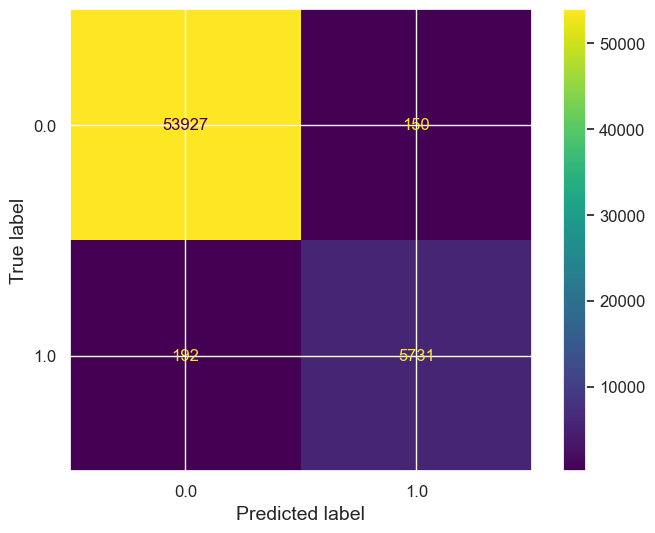

In [42]:
y_hat_train_0 = bin_sgd_clf.predict(X_train)

cm_display = ConfusionMatrixDisplay.from_predictions(
    y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

In [43]:
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.97      0.97      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



##### **Cross Validation**

In [44]:
estimator = SGDClassifier(loss='log',
                          penalty='l2',
                          max_iter=100,
                          warm_start=False,
                          eta0=0.01,
                          alpha=0,
                          learning_rate='constant',
                          random_state=1729)

In [45]:
cv_bin_clf = cross_validate(estimator, X_train, y_train_0, cv=5,
                            scoring=['precision', 'recall', 'f1'],
                            return_train_score=True,
                            return_estimator=True)
cv_bin_clf

{'fit_time': array([1.03657675, 1.08394241, 1.08475947, 1.15117502, 1.01892543]),
 'score_time': array([0.03762484, 0.03162169, 0.03169918, 0.03145504, 0.03181505]),
 'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, random_state=1729)],
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.95952782]),
 'train_precision': array([0.97419355, 0.97321046, 0.96473818, 0.97701149, 0.96404399]),
 'test_recall': array([

* From the above result, we can see that **logistic regression is better than the perceptron**.

* However, it is good to check the weight values of all the features and decide whether regularization could be of any help.


In [46]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_

print('Bias :', bias)
print('Shape of weights :', weights.shape)
print('Shape of bias :', bias.shape)

Bias : [-5.01034596]
Shape of weights : (1, 784)
Shape of bias : (1,)


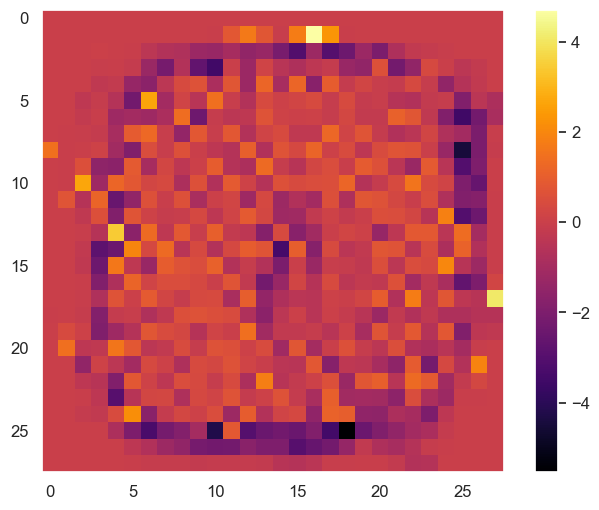

In [47]:
plt.figure()
plt.imshow(weights.reshape(28, 28), cmap='inferno')

plt.grid(False)
plt.colorbar()
plt.show()

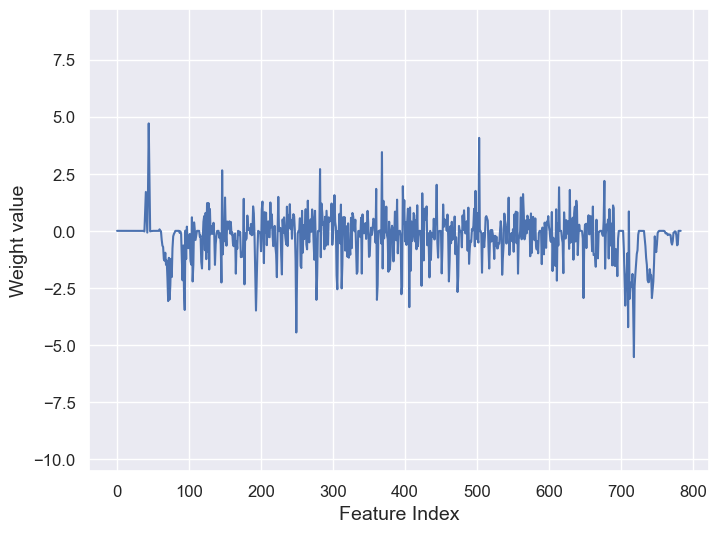

In [48]:
plt.figure() 
plt.plot(np.arange(0,784),weights[0,:])

plt.ylim(np.min(weights[0])-5,np.max(weights[0])+5)
plt.grid(True)

plt.xlabel('Feature Index')
plt.ylabel('Weight value')
plt.show()

* It is interesting to observe that how many weight values are exactly zero.

* Those features contribute nothing in the classification.

In [49]:
zero_weight_idx = np.where(weights[0]==0)
print(len(zero_weight_idx[0]))

# num_zero_w = weights.shape[1]-np.count_nonzero(weights) 
# print("Number of weights with value zero".format(num_zero_w))

67


From the above plot, it is also obvious that regularization is not required.

#### **Training with regularization**

However, what happens to the performance of the model if we penalize, out of temptation, the weight values even to a smaller degree.

In [50]:
bin_sgd_clf_l2 = SGDClassifier(loss='log',
                               penalty='l2',
                               eta0=0.01,
                               alpha=0.001,
                               max_iter=1,
                               warm_start=True,
                               learning_rate='constant',
                               random_state=1729
                               )

In [51]:
loss = [] 
iter =100

for i in range(iter):
  bin_sgd_clf_l2.fit(X_train, y_train_0)
  y_pred = bin_sgd_clf_l2.predict_proba(X_train)
  loss.append(log_loss(y_train_0,y_pred))

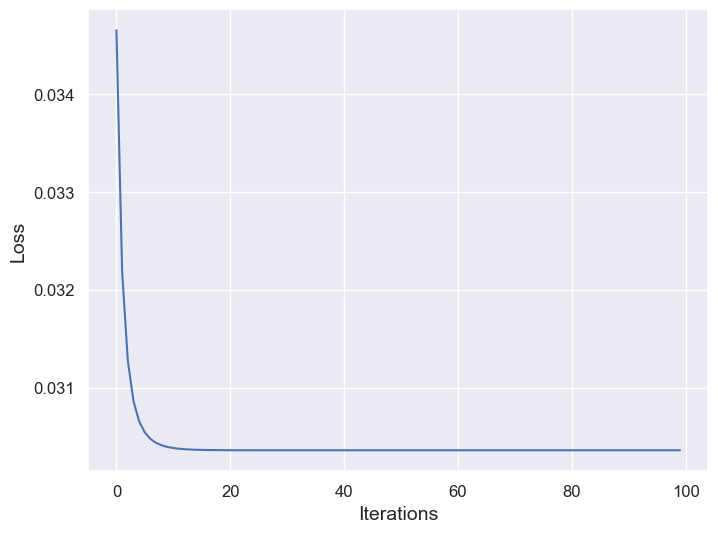

In [52]:
plt.figure()
plt.plot(np.arange(iter), loss)

plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

Let us calculate training and testing accuracy.

In [53]:
print('Training accuracy : {0:.4f}'.format(bin_sgd_clf_l2.score(X_train,y_train_0)))

print('Testing accuracy : {0:.4f}'.format(bin_sgd_clf_l2.score(X_test,y_test_0)))

Training accuracy : 0.9907
Testing accuracy : 0.9905


Let's compute Precision, recall and f1-score for the model.

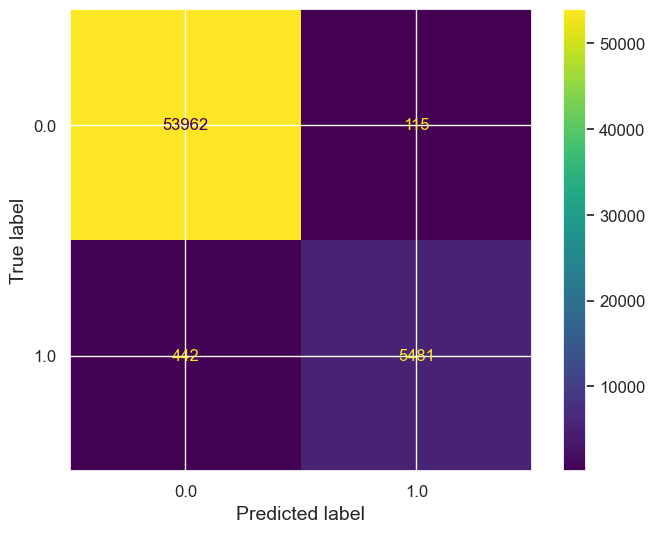

In [54]:
y_hat_train_0 = bin_sgd_clf_l2.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g')

In [55]:
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



In [56]:
weights = bin_sgd_clf_l2.coef_
bias = bin_sgd_clf_l2.intercept_

print('Bias :', bias)
print('Shape of weights :', weights.shape)
print('Shape of bias :', bias.shape)

Bias : [-4.43002876]
Shape of weights : (1, 784)
Shape of bias : (1,)


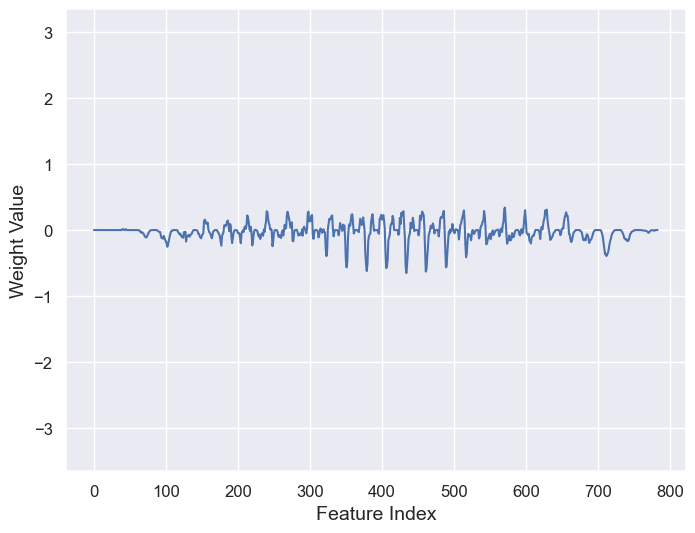

In [57]:
plt.figure()
plt.plot(np.arange(0, 784), weights[0, :])

plt.ylim(np.min(weights[0]-3), np.max(weights[0])+3)
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.grid(True)
plt.show()

Zero weights calculation 

**Note**: Zero weights can't contribute to features.

In [58]:
num_zero_w = len(np.where(weights == 0)[0])
print('Number of zero weight count:', num_zero_w)

Number of zero weight count: 67


#### **Displaying input image and its prediction**

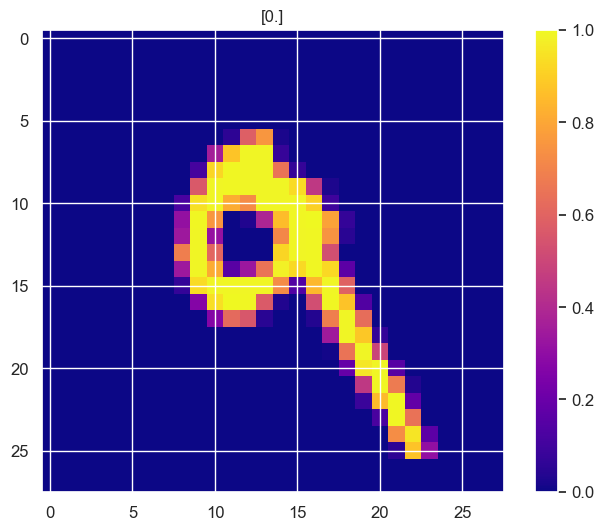

In [59]:
index = 7  # try some other index
plt.imshow(X_test[index, :].reshape(28, 28), cmap='plasma')
plt.colorbar()
pred = bin_sgd_clf_l2.predict(X_test[index].reshape(1, -1))
plt.title(str(pred))
plt.show()


Let's plot a few images and their respective predictions with SGDClassifier without regularization.

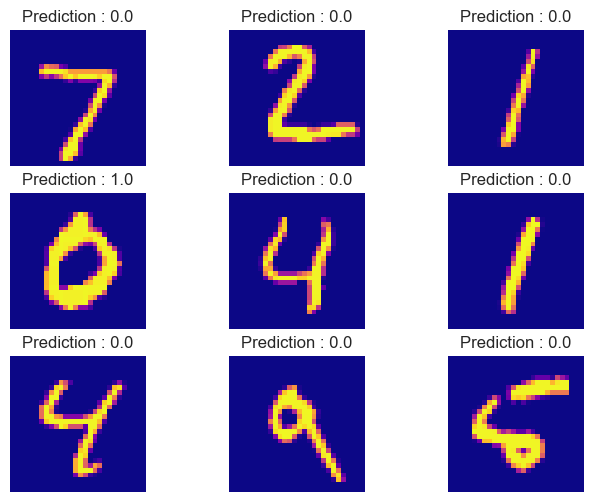

In [60]:
y_hat_test_0 = bin_sgd_clf.predict(X_test) 

num_images = 9  
factor = np.int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 

for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X_test[index+j].reshape(28,28),cmap='plasma')
        
        ax[i,j].set_title('Prediction : {0}'.format(str(y_hat_test_0[index+j])))
        ax[i,j].set_axis_off()

In [61]:
indx_0 = np.where(y_test_0 == 1) 

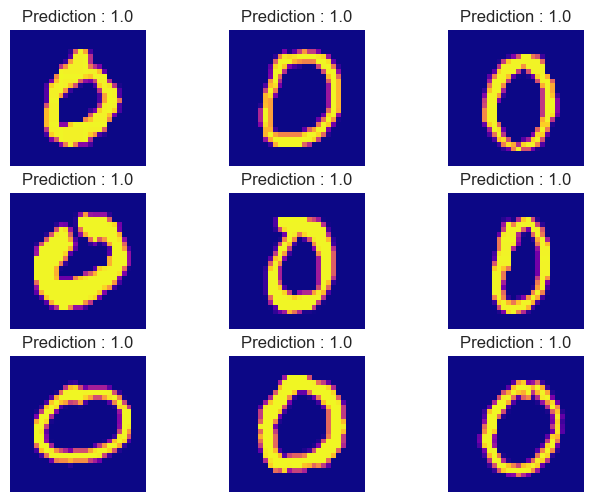

In [62]:
zeroImgs= X_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]

num_images = 9 
factor = np.int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 

for i in range(factor):
    index = idx_offset + i*(factor)
    
    for j in range(factor):
        ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='plasma')
        ax[i,j].set_title('Prediction : {0}'.format(str(zeroLabls[index+j])))
        ax[i,j].set_axis_off()

#### **Hyperparameter Tuning**

* We have to use `cross-validate` folds and mesure the same metrics across these folds for different values of hyper-parameters.

* Logistic regression uses **SGD** solver and hence the two important hyperparameters include : 
    * **learning rate** 

    * **regularization rate** 

* For the moment, we skip penalizing the parameters of the model and just search for a better learning rate using `RandomizedSearchCV()` and draw the value from the uniform distribution.


In [63]:
lr_grid = loguniform(1e-2,1e-1)

* **Note**:  `lr_grid` is an object that contains a method called `rvs()`, which can be used to get the samples of given size.

* Therefore, we pass this `lr_grid` object to `RandomizedSearchCV()`. Internally, it makes use of this `rvs()` method for sampling.

In [64]:
print(lr_grid.rvs(3,random_state=42))

[0.02368864 0.0892718  0.05395031]


In [65]:
estimator = SGDClassifier(loss='log',
                          penalty='l2',
                          max_iter=1,
                          warm_start=True,
                          eta0=0.01,
                          alpha=0,
                          learning_rate='constant',
                          random_state=1729)

scores = RandomizedSearchCV(estimator,
                            param_distributions={'eta0': lr_grid},
                            cv=5,
                            scoring=['precision', 'recall', 'f1'],
                            n_iter=5,
                            refit='f1')


In [66]:
scores.fit(X_train,y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, random_state=1729,
                                           warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EACF3179D0>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [67]:
scores.cv_results_

{'mean_fit_time': array([0.36316314, 0.36188035, 0.35664506, 0.38230977, 0.37398672]),
 'std_fit_time': array([0.02291225, 0.00057418, 0.00937268, 0.01725963, 0.01761479]),
 'mean_score_time': array([0.02518334, 0.03115973, 0.03164244, 0.03147736, 0.03077202]),
 'std_score_time': array([0.00745123, 0.00027316, 0.00414258, 0.00027661, 0.00168972]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                    0.05395030966670228, 0.039687933304443715,
                    0.01432249371823025],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'eta0': 0.02368863950364078},
  {'eta0': 0.08927180304353625},
  {'eta0': 0.05395030966670228},
  {'eta0': 0.039687933304443715},
  {'eta0': 0.01432249371823025}],
 'split0_test_precision': array([0.93327909, 0.86936937, 0.90101325, 0.91304348, 0.94356846]),
 'split1_test_precision': array([0.95633562, 0.94230769, 0.94839255, 0.95068027, 0.959447

Let us pick the best estimator from the results

In [68]:
best_bin_clf = scores.best_estimator_
best_bin_clf

SGDClassifier(alpha=0, eta0=0.01432249371823025, learning_rate='constant',
              loss='log', max_iter=1, random_state=1729, warm_start=True)

In [69]:
y_hat_train_best_0 = best_bin_clf.predict(X_train)
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



#### **Other Evaluation metrics**

##### **1. Precision / Recall Tradeoff**

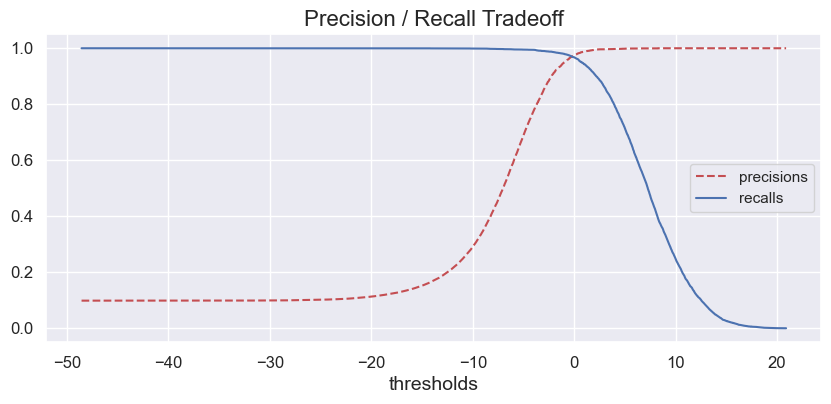

In [70]:
y_scores = bin_sgd_clf.decision_function(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0,y_scores)

plt.figure(figsize=(10,4)) 
plt.plot(thresholds,precisions[:-1],'r--',label='precisions')
plt.plot(thresholds,recalls[:-1],'b-',label='recalls')

plt.title('Precision / Recall Tradeoff' ,fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('thresholds')
plt.show()

##### **2. Precision Recall Curve**

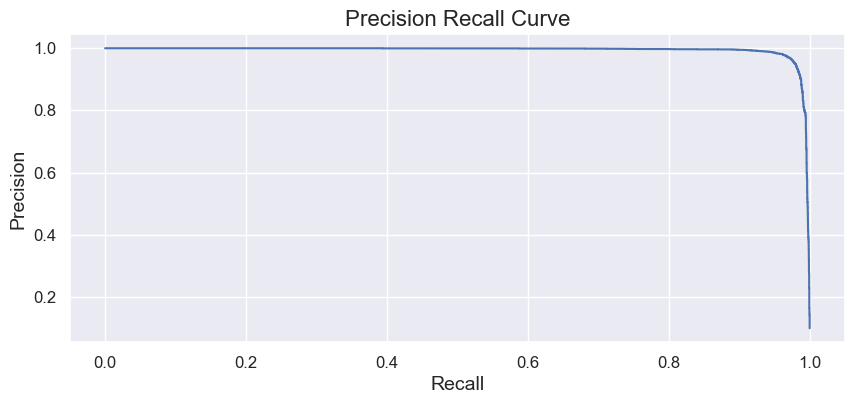

In [71]:
plt.figure(figsize=(10, 4))
plt.plot(recalls[:-1], precisions[:-1], 'b-')

plt.title('Precision Recall Curve', fontsize=16)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

##### **3. ROC curve**

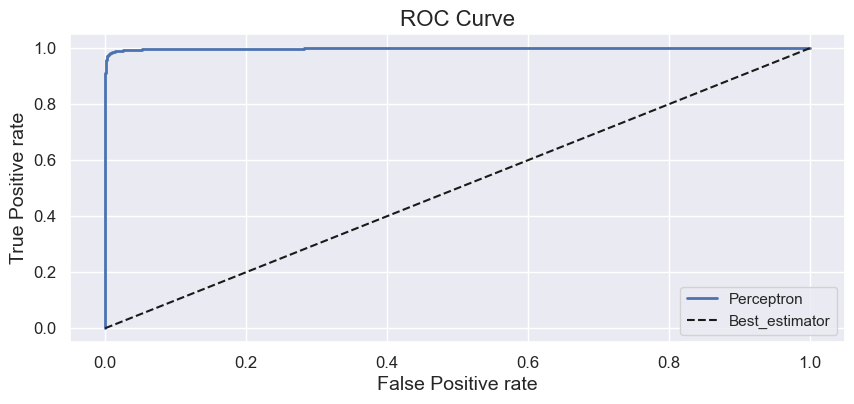

In [72]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, linewidth=2, label='Perceptron')
plt.plot([0, 1], [0, 1], 'k--', label='Best_estimator')

plt.title('ROC Curve', fontsize=16)
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.grid(True)
plt.legend()
plt.show()

##### **4. ROC-AUC score**

In [73]:
auc = roc_auc_score(y_train_0, y_scores)
print('AUC : {0:.6f}'.format(auc))

AUC : 0.998627


# Logistic Regression

   

* In the previous setup, we used `SGDClassifier` to train 0-detector model in an iterative manner.
  - We can also train such a classifier by solving a set of equations obtained by setting the derivative of loss w.rt. weights to 0.
  - These are not linear equations and therefore we need a different set of solvers

* Skleam uses solvers like `liblinear`, `newton-cg`, `sag`, `saga` and `lbfgs` to find the optimal weights.

* Regularization is applied by default.

+ Default Parameters:

 > LogisticRegression(**penalty: ‘l2’, dual: False, tol: 0.0001, C: 1.0, fit_intercept: True, intercept_scaling: 1, class_weight: None, random_state: None, solver: ‘lbfgs’, max_iter: 100, multi_class: ‘auto’, verbose: 0, warm_start: False, n_jobs: None, l1_ratio: None**)


+ Note some of the important default parameters:
  - Regularization: `penalty = 'l2'`
  - Regularization rate: `c=1`
  - Solver: `solver = ‘lbfgs"`
  
+ Let's implement LogisticRegression() without regularization by setting the parameter C = oo. Therefore, we may expect performance close to `SGDClassifier`without regularization.

 


Training without regularization

In [74]:
pipe_logit = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729, solver='lbfgs', C=np.infty))
# C = np.infty means 0 regularization
pipe_logit.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

Hyper-parameter search

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

grid_Cs = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

scaler = MinMaxScaler()

logreg = LogisticRegression(C=1.0, random_state=1729) # initialized C with some value, and use grid_Cs for GridSearchCV

pipe = Pipeline(steps=[('scaler', scaler), ('logistic', logreg)])
pipe_logit_cv = GridSearchCV(pipe, param_grid={'logistic__C': grid_Cs}, scoring='f1')
pipe_logit_cv.fit(X_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

In [78]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

In [79]:
pipe_logit_cv.best_score_

0.9579654953103655

In [80]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

# LogisticRegressionCV (instead of GridSearchCV)

In [82]:
from sklearn.linear_model import LogisticRegressionCV
estimator = LogisticRegressionCV(cv=5, scoring='f1', random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(), estimator)
logit_cv.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

In [83]:
lr_y_hat_0 = pipe_logit.predict(X_test)
lr_gs_y_hat_0 = pipe_logit_cv.best_estimator_.predict(X_test)
lr_cv_y_hat_0 = logit_cv.predict(X_test)

In [84]:
precision_lr = precision_score(y_test_0, lr_y_hat_0)
recall_lr = recall_score(y_test_0, lr_y_hat_0)

precision_lr_gs = precision_score(y_test_0, lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

precision_lr_cv = precision_score(y_test_0, lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)

In [85]:
print(f'LogReg: precision={precision_lr}, recall={recall_lr}')
print(f'GridSearch: precision={precision_lr_gs}, recall={recall_lr_gs}')
print(f'LogRegCV: precision={precision_lr_cv}, recall={recall_lr_cv}')

LogReg: precision=0.9515151515151515, recall=0.9612244897959183
GridSearch: precision=0.9564336372847011, recall=0.963265306122449
LogRegCV: precision=0.9546370967741935, recall=0.9663265306122449


LogisticRegression classifier obtained through GridSearchCV has the highest precision

In [86]:
y_scores_lr = pipe_logit.decision_function(X_test)
precision_lr, recalls_lr, threshold_lr = precision_recall_curve(y_test_0, y_scores_lr)

y_scores_lr_gs = pipe_logit_cv.decision_function(X_test)
precision_lr_gs, recalls_lr_gs, threshold_lr_gs = precision_recall_curve(y_test_0, y_scores_lr_gs)

y_scores_lr_cv = logit_cv.decision_function(X_test)
precision_lr_cv, recalls_lr_cv, threshold_lr_cv = precision_recall_curve(y_test_0, y_scores_lr_cv)

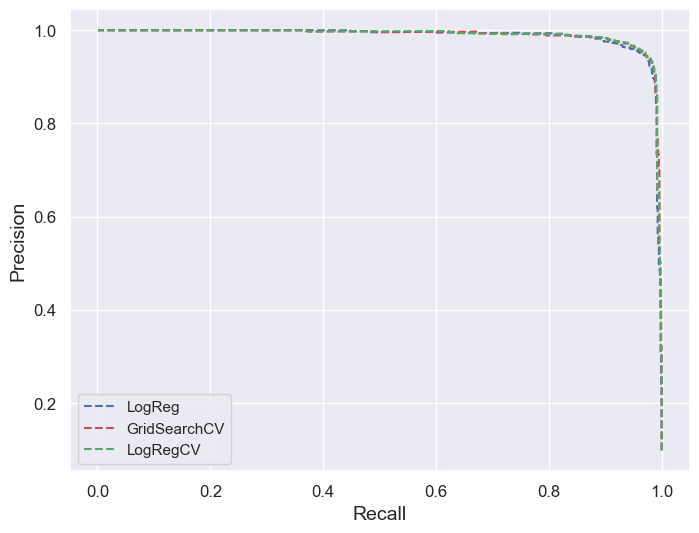

In [87]:
plt.figure()
plt.plot(recalls_lr[:-1], precision_lr[:-1], 'b--', label='LogReg')
plt.plot(recalls_lr_gs[:-1], precision_lr_gs[:-1], 'r--', label='GridSearchCV')
plt.plot(recalls_lr_cv[:-1], precision_lr_cv[:-1], 'g--', label='LogRegCV')

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.legend(loc='lower left')

Now that the PR-curve for all three classifier overlap each other significantly.

Let's calculate area under the PR-Curve

In [95]:
from sklearn.metrics import auc

auc_lr = auc(recalls_lr[:-1],precision_lr[:-1])
auc_lr_gs = auc(recalls_lr_gs[:-1],precision_lr_gs[:-1])
auc_lr_cv = auc(recalls_lr_cv[:-1],precision_lr_cv[:-1])

In [97]:
print("Area under curve for Log Reg", auc_lr)
print("Area under curve for Log Reg with grid search", auc_lr_gs)
print("Area under curve for Log Reg CV", auc_lr_cv)

Area under curve for Log Reg 0.9871337497759658
Area under curve for Log Reg with grid search 0.9886520703587929
Area under curve for Log Reg CV 0.9886307057884005


All three have roughly the same area under curve, with grid search cv and LRCV, it's bit higher than the simple Log Reg

Confusion Matrix

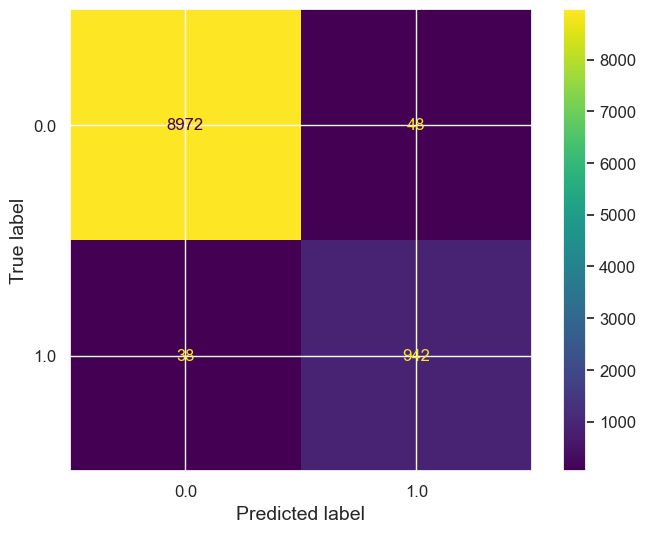

In [88]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_y_hat_0, values_format='0.5g') # From logistic regression

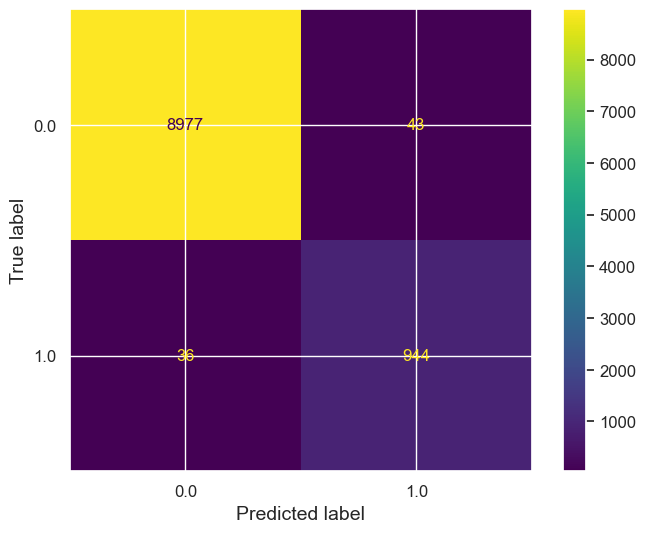

In [89]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_gs_y_hat_0, values_format='0.5g') # From GridSearchCV

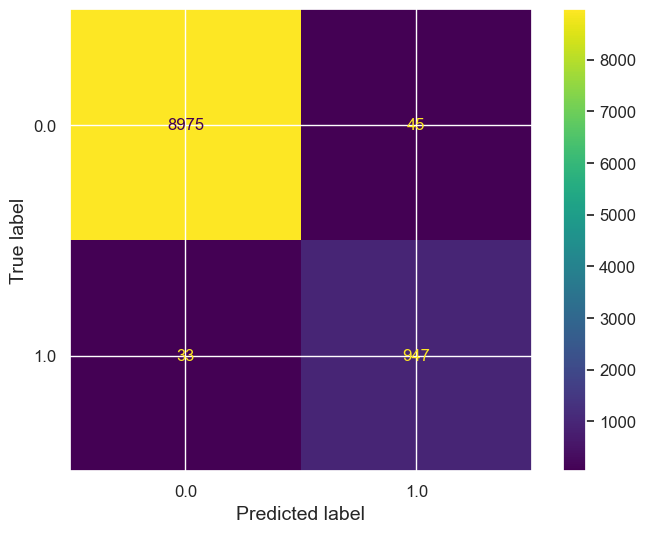

In [98]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_cv_y_hat_0, values_format='0.5g') # LogisticRegressionCV

## Classsification using Ridge Classifier

- Ridge Classifier casts the problem as the **least-squares classification** & finds the optimal weight using some matrix decompostion technique such as **Singular-Value Decompostion (SVD)**.

- To train the ridge classifier, the labels should be y belong to {-1,1}

- The classifer also by default implements **L2 regularization**. However, we first implement it without regularization by setting alpha = 0

In [99]:
# Getting Data

from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [104]:
#Data Preprocessing and Splitting

X = np.array(X)
y = np.array(y)

In [105]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [106]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [107]:
#initialize new variable names with all 0
y_train_0 = -1 * np.ones(y_train.shape[0])
y_test_0 = -1 * np.ones(y_test.shape[0])

#find indices of digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[-1.  1. -1. ... -1. -1. -1.]


### Model Building

First taking a look into the parameters of the class :

>* **RidgeClassifier( alpha=1.0, *, fit_intercept=True, copy_X=True, max_iter=None, tol=0.001, class_weight=None, solver='auto', positive=False, random_state=None)*

In [113]:
from sklearn.linear_model import RidgeClassifier

estimator = RidgeClassifier(alpha=0) # No regularization
pipe_ridge = make_pipeline(MinMaxScaler(), estimator)
pipe_ridge.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))])

Performance

In [114]:
y_hat_test_0 = pipe_ridge.predict(X_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.95      0.88      0.92       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000



Cross-validation

In [119]:
cv_bin_ridge_clf = cross_validate(pipe_ridge, X_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], return_train_score=True, return_estimator=True)
print(cv_bin_ridge_clf)

{'fit_time': array([8.14302897, 8.02346611, 8.1275816 , 8.05872726, 8.45115542]), 'score_time': array([0.11628079, 0.11014509, 0.09425354, 0.10845852, 0.11050272]), 'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))])], 'test_precision': array([0.96597353, 0.95037453, 0.96915888, 0.96246391, 0.96943649]), 'train_precision': array([0.97179426, 0.96794721, 0.96522754, 0.96807512, 0.96707432]), 'test_recall': array([0.86317568, 0.85726351, 0.87510549, 0.84388186, 

In [120]:
best_estimator_id = np.argmax(cv_bin_ridge_clf['train_f1'])
print(best_estimator_id)

2


In [121]:
best_estimator = cv_bin_ridge_clf['estimator'][best_estimator_id]

In [122]:
y_hat_test_0 = best_estimator.predict(X_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.95      0.88      0.92       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000



# Multiclass SGDClassifier (log loss)

In this notenook, we will implement multiclass classification using LogisticRegression with both :

- SGD i.e. SGDClassifier(loss='log')

- solvers i.e. LogisticRegression(solver='lbfgs')

In [129]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, 
                          alpha=0, learning_rate='constant', random_state=1729)
pipe_sgd_ovr = make_pipeline(MinMaxScaler(), estimator)

In [130]:
Loss = []
iterations = 100
for i in range(iterations):
  pipe_sgd_ovr.fit(X_train, y_train)  # train on all classes
  y_pred = pipe_sgd_ovr.predict_proba(X_train)
  Loss.append(log_loss(y_train, y_pred))

Text(0, 0.5, 'Loss')

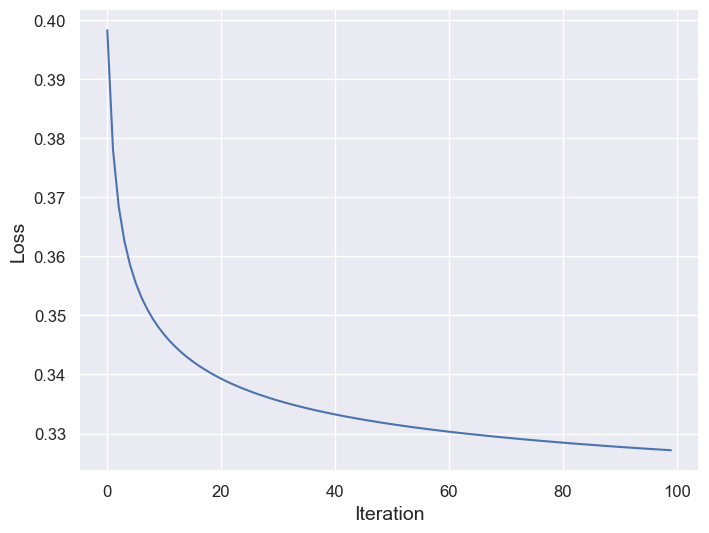

In [131]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [132]:
y_hat = pipe_sgd_ovr.predict(X_test)

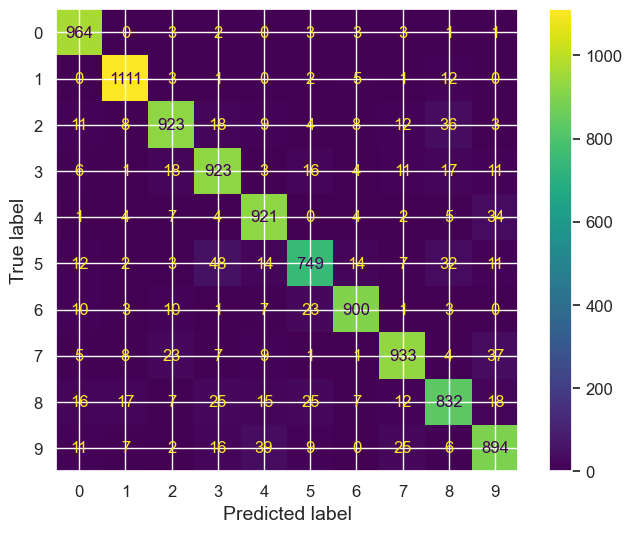

In [133]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='0.5g')

In order to manually calculate the precision and recall, follow this procedure on the above ConfusionMatrix.

- True positive: diagonal position, cm(x, x).
- False positive: sum of column x (without main diagonal), sum(cm(:, x))-cm(x, x).
- False negative: sum of row x (without main diagonal), sum(cm(x, :), 2)-cm(x, x).

Note that the same report can be automatically obtained through the function classification_report

In [134]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



# Multiclass LogisticRegression (solvers)

In [135]:
pipe_logit_ovr = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729, solver='lbfgs', C=np.infty)) 
# C=np.infty indicates no regularization

pipe_logit_ovr.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

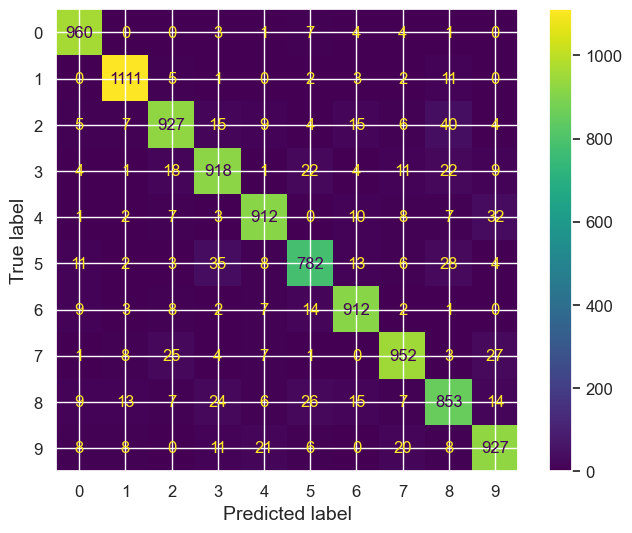

In [136]:
y_hat = pipe_logit_ovr.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='0.5g')

In [137]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



## Naive Bayes Classifier

- Naive Bayes classifier applies Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

For a given class variable and dependent feature vector x1 through xm, the naive conditional independence assumption is given by:
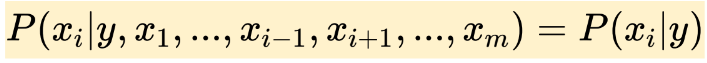

**Naive Bayes learners and classifiers can be extremely fast compared to more sophisticated methods.**

### List of NB Classifiers

**Implemented in sklearn.naive_bayes module**

#### ComplementNB : 
   * Complement Naive Bayes is designed for imbalanced datasets, where one class significantly outnumbers the other(s). It is particularly useful for text classification tasks, similar to MultinomialNB, when dealing with imbalanced text data.<br><br>
   * **How it's different**: ComplementNB is a variant of MultinomialNB that tries to correct for class imbalances by using statistics from the complement of each class. It can perform well when one class is dominant.
<br><br>
#### GaussianNB : 
  * where the features (attributes) are continuous and assumed to follow a Gaussian (normal) distribution. It's well-suited for real-valued data.<br><br>
  * **How it's different**: GaussianNB assumes that each feature follows a Gaussian distribution, meaning it models the data using the mean and standard deviation of each feature. It's suitable for data with continuous variables.
<br><br>
#### BernoulliNB : 
   * typically used when dealing with binary or Boolean features, where each feature is either true or false (1 or 0).It's often used in text classification tasks where the presence or absence of words or features is important.<br><br>
   * **How it's different**:  BernoulliNB models binary data using Bernoulli distribution. It's suitable for data with binary features, like text data represented as a bag of words.
<br><br>
#### CategoricalNB : 
   *  Categorical Naive Bayes is used for categorical data, where the features are discrete and categorical, such as color, type, or labels<br><br>
   *  **How it's different**: CategoricalNB assumes that features follow a categorical distribution, and it works well when dealing with discrete, non-numeric data.
<br><br>
#### MultinomialNB :
  * Multinomial Naive Bayes is commonly applied to text classification tasks, especially when dealing with discrete data like word counts or term frequencies. It's suitable for problems where the features represent the frequency or count of events.<br><br>
  * **How it's different**:MultinomialNB assumes that features follow a multinomial distribution. It's often used in natural language processing for tasks like spam classification or sentiment analysis.


# Text Classification using Naive Bayes classifier

In this notebook, we will use Niave Bayes classifier for classifying text.

`Naive bayes` is used for `text classification & spam detection tasks`.

Here is an example as to how to perform the text classification with Naive Bayes Classifier.

In [13]:
import numpy as np 

# data loading  
from sklearn.datasets import fetch_20newsgroups 

# preprocessing 
from sklearn.feature_extraction.text import TfidfVectorizer 

# model / estimator 
from sklearn.naive_bayes import MultinomialNB,ComplementNB

# pipeline utilty 
from sklearn.pipeline import Pipeline 

# model evaluation 
from sklearn.metrics import ConfusionMatrixDisplay 

In [3]:
# plotting 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

### Getting dataset

We will be using 20 newsgroup dataset for classification.

As a first step, let's download 20 newsgroup dataset with fetch_20newsgroup API.

In [4]:
data = fetch_20newsgroups()

#Lets look at the name of the classes.

data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [26]:
?fetch_20newsgroups

**There are 20 categories in the dataset. For simplicity, we will select 4 of these categories and download their training and test set.**

In [6]:
categories = ['talk.religion.misc',
              'soc.religion.christian', 'sci.space', 'comp.graphics']

train = fetch_20newsgroups(subset='train' ,categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Lets look at a sample training document :

In [7]:
print(train.data[1])

From: MANDTBACKA@finabo.abo.fi (Mats Andtbacka)
Subject: Re: If There Were No Hell
Organization: Unorganized Usenet Postings UnInc.
Lines: 26

In <May.5.02.51.25.1993.28737@athos.rutgers.edu> shellgate!llo@uu4.psi.com writes:

> Here's a question that some friends and I were debating last night.
> Q: If you knew beyond all doubt that hell did not exist and that
>    unbelievers simply remained dead, would you remain a Christian?

      (Reasoning pertinent to believing Xians deleted for space)

      It strikes me, for no apparent reason, that this is reversible.
I.e., if I had proof that there existed a hell, in which I would be
eternally punished for not believing in life, would that make me a Xian?
(pardon my language) _Bloody_hell_no_!

      ...Of course, being merely a reversal of your thinking, this
doesn't add anything _new_ to the debate, but...

> Several friends disagreed, arguing the fear of hell was necessary
> to motivate people to Christianity. To me that fatally undercu

This data is different than what we have seen so far. Here the training data contains document in text form.


## Data Preprocessing and Modeling

As we have mentioned in the first week of MLT, we need to convert th text data to numeric form.

**`TfidfVectorizer`** is one such API that **converts text input into a vector of numerical values**.

We will use `TfidfVectorizer` as as preprocessing step to obtain `feature vector` corresponding to the text document.

We will be using **`MultinomialNB classifier`** for categorizing documents from 20 newsgroup corpus.

In [8]:
from sklearn.pipeline import make_pipeline
model = make_pipeline(TfidfVectorizer() ,MultinomialNB())

#Lets train the model.

model.fit(train.data ,train.target)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

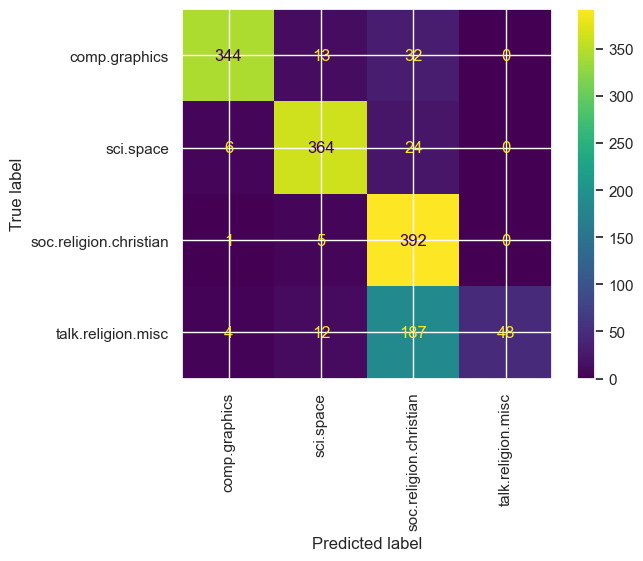

In [9]:
# Lets first predict the labels for the test set and then calculate the confusion matrix for th test set.

ConfusionMatrixDisplay.from_estimator(model, test.data ,test.target ,display_labels=test.target_names ,xticks_rotation='vertical')

plt.show()

##### Obsereve that :

- There is a confusion between the documents of class `soc.religion.christian` and `talk.religion.misc` ,which is along the expected lines.

- The classes `comp.graphics` and `sci.space` are well separated by such a simple classifier.

Now we have the tool to classify statements into one of these four classes.

- Make use of predict function on pipeline for predicting category of a test string.

In [11]:
def predict_category(s, train=train ,model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Using the function of prediction :

In [148]:
predict_category('sending a payload to the ISS')

'sci.space'

In [149]:
predict_category('what is your screen resolution')

'comp.graphics'

In [150]:
predict_category('the Seven Sacraments are')

'soc.religion.christian'

In [10]:
predict_category('discussing islam')

NameError: name 'predict_category' is not defined

In [15]:
model_cb = make_pipeline(TfidfVectorizer() ,ComplementNB())

#Lets train the model.

model_cb.fit(train.data ,train.target)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('complementnb', ComplementNB())])

In [23]:
y_pred = model_cb.predict(test.data)


In [30]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
print(classification_report(test.target,y_pred, target_names=categories))


                        precision    recall  f1-score   support

    talk.religion.misc       0.95      0.94      0.94       389
soc.religion.christian       0.93      0.95      0.94       394
             sci.space       0.73      0.97      0.83       398
         comp.graphics       0.96      0.45      0.61       251

              accuracy                           0.86      1432
             macro avg       0.89      0.83      0.83      1432
          weighted avg       0.88      0.86      0.85      1432



In [43]:
cm = confusion_matrix(test.target,y_pred)
cm

array([[365,  12,  12,   0],
       [ 12, 373,   9,   0],
       [  2,   4, 387,   5],
       [  5,  12, 122, 112]], dtype=int64)

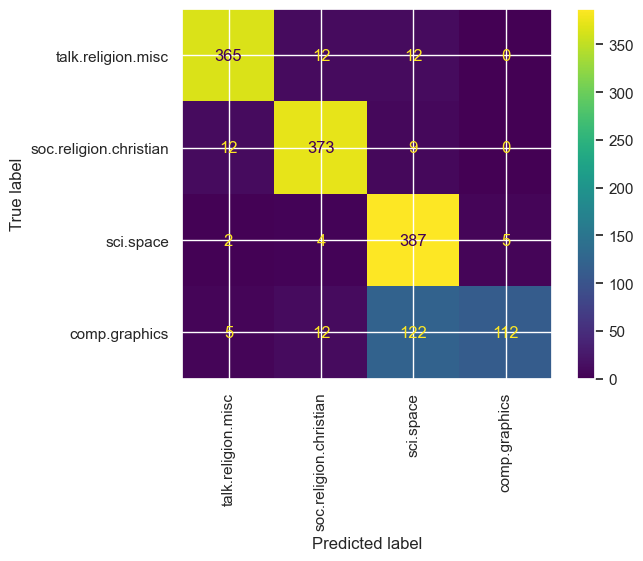

In [42]:
ConfusionMatrixDisplay.from_predictions(test.target,y_pred, display_labels=categories,xticks_rotation='vertical')
plt.show()

Here we can observe the confusion between the classes of soc.religion.christian and talk.religion.misc mentioned previously.